In [2]:
import pandas as pd

# Define inputs
years = ["2024", "2030", "2045"]
demand_ranges = [(1.4, 1.4), (2.4, 3.3), (9.3, 13.7)]
planned_supply = [2.66, 4.78, 6.65]
technical_supply = [3.27, 7.085, 10.9]
allocations = [i / 100 for i in range(30, 101, 10)]  # 30% to 100% in 10% steps

# Function to calculate coverage
def calculate_coverage(supply, demand_range, allocation):
    allocated_supply = supply * allocation
    coverage_min = round(allocated_supply / demand_range[1] * 100)
    coverage_max = round(allocated_supply / demand_range[0] * 100)
    return f"{coverage_min}–{coverage_max}%" if coverage_min != coverage_max else f"{coverage_min}%"

# Build table for both scenarios
rows = []
for scenario, supply_list in [("Base", planned_supply), ("Technical potential", technical_supply)]:
    for i, year in enumerate(years):
        demand = demand_ranges[i]
        supply = supply_list[i]
        row = {
            "Year": year,
            "Scenario": scenario,
            "Mean H₂ Supply (Mt)": supply,
            "H₂ Demand (Mt)": f"{demand[0]}–{demand[1]}"
        }
        for alloc in allocations:
            coverage = calculate_coverage(supply, demand, alloc)
            row[f"{int(alloc*100)}%"] = coverage
        rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)
print(df)
#import ace_tools as tools; tools.display_dataframe_to_user(name="H₂ Demand Coverage Calculation", dataframe=df)


   Year             Scenario  Mean H₂ Supply (Mt) H₂ Demand (Mt)     30%  \
0  2024                 Base                2.660        1.4–1.4     57%   
1  2030                 Base                4.780        2.4–3.3  43–60%   
2  2045                 Base                6.650       9.3–13.7  15–21%   
3  2024  Technical potential                3.270        1.4–1.4     70%   
4  2030  Technical potential                7.085        2.4–3.3  64–89%   
5  2045  Technical potential               10.900       9.3–13.7  24–35%   

       40%       50%       60%       70%       80%       90%      100%  
0      76%       95%      114%      133%      152%      171%      190%  
1   58–80%   72–100%   87–120%  101–139%  116–159%  130–179%  145–199%  
2   19–29%    24–36%    29–43%    34–50%    39–57%    44–64%    49–72%  
3      93%      117%      140%      163%      187%      210%      234%  
4  86–118%  107–148%  129–177%  150–207%  172–236%  193–266%  215–295%  
5   32–47%    40–59%    48–70

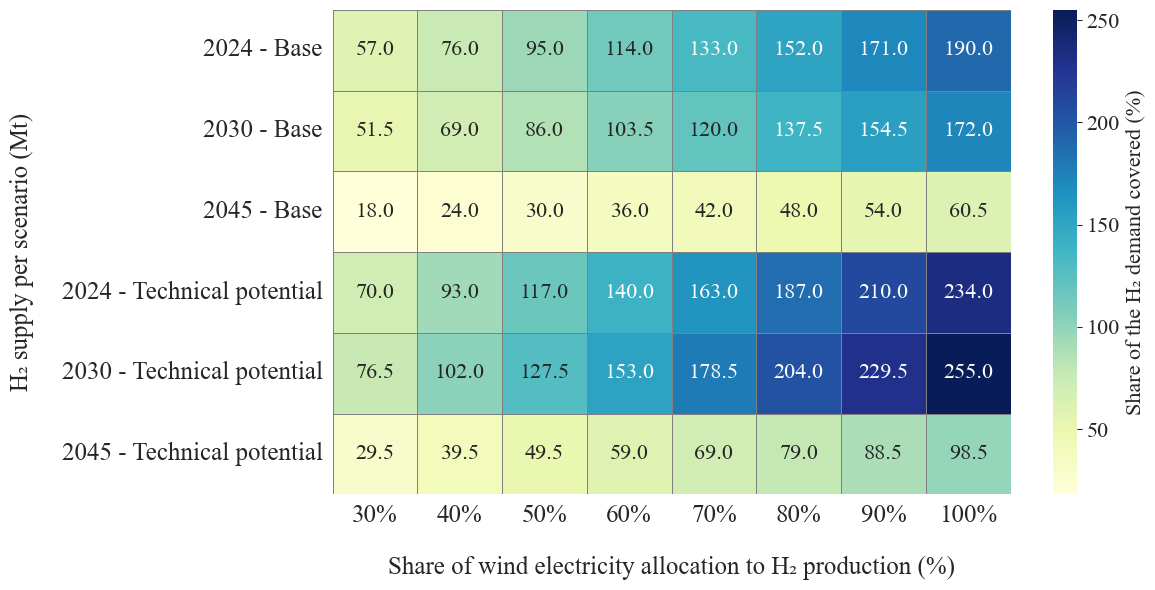

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'

# Add a label for rows
df["Label"] = df["Year"] + " - " + df["Scenario"]

# Parse percentage values to numeric midpoints
alloc_cols = [col for col in df.columns if "%" in col]

def parse_percent(val):
    val = val.replace('%', '')
    if '–' in val:
        a, b = val.split('–')
        return (float(a) + float(b)) / 2
    return float(val)

df_numeric = df.copy()
for col in alloc_cols:
    df_numeric[col] = df_numeric[col].apply(parse_percent)

# Prepare heatmap data
heatmap_data = df_numeric.set_index("Label")[alloc_cols]

# Plot heatmap
plt.figure(figsize=(12, 6))


ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Share of the of H₂ demand covered (%)'},
    annot_kws={'fontsize': 16}


)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Share of the H₂ demand covered (%)', fontsize=16)
#plt.title("H₂ Demand Coverage by Onshore Wind Under Allocation Scenarios")
plt.xlabel("Share of wind electricity allocation to H₂ production (%)", fontsize=18, labelpad=20)
plt.ylabel("H₂ supply per scenario (Mt)", fontsize=18, labelpad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()


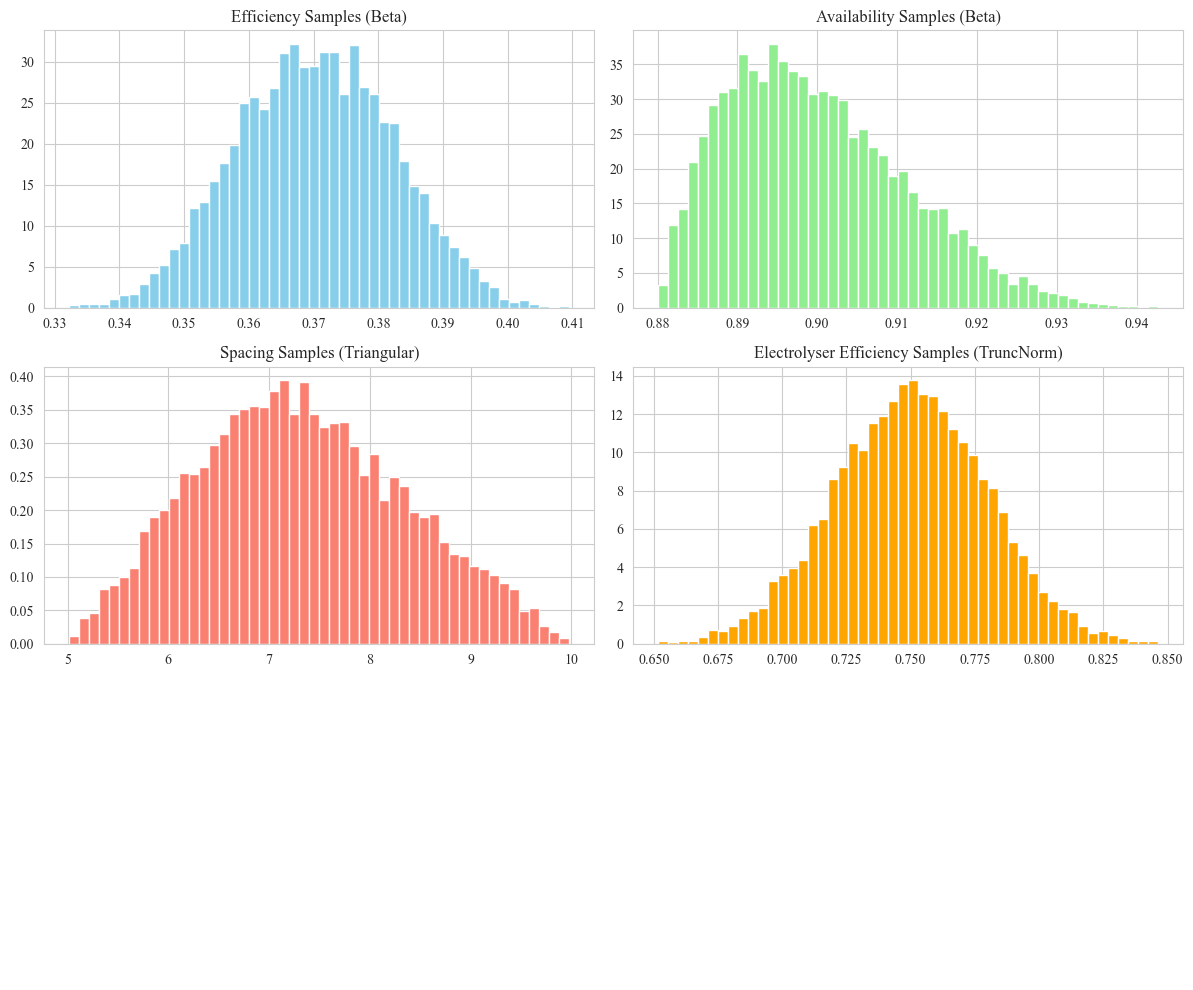

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, triang, truncnorm

# Set seed and sample size
np.random.seed(42)
n_outer = 10000

# Sample from distributions
efficiency_samples = beta.rvs(a=8, b=8, loc=0.32, scale=0.10, size=n_outer)
availability_samples = beta.rvs(a=2, b=5, loc=0.88, scale=0.07, size=n_outer)
spacing_samples = triang.rvs(c=(7 - 5) / (10 - 5), loc=5, scale=5, size=n_outer)
electrolyser_efficiency_samples = truncnorm.rvs(
    (0.65 - 0.75) / 0.03, (0.85 - 0.75) / 0.03, loc=0.75, scale=0.03, size=n_outer
)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

axs[0, 0].hist(efficiency_samples, bins=50, density=True, color='skyblue')
axs[0, 0].set_title('Efficiency Samples (Beta)')

axs[0, 1].hist(availability_samples, bins=50, density=True, color='lightgreen')
axs[0, 1].set_title('Availability Samples (Beta)')

axs[1, 0].hist(spacing_samples, bins=50, density=True, color='salmon')
axs[1, 0].set_title('Spacing Samples (Triangular)')

axs[1, 1].hist(electrolyser_efficiency_samples, bins=50, density=True, color='orange')
axs[1, 1].set_title('Electrolyser Efficiency Samples (TruncNorm)')

# Hide unused subplots
axs[2, 0].axis('off')
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


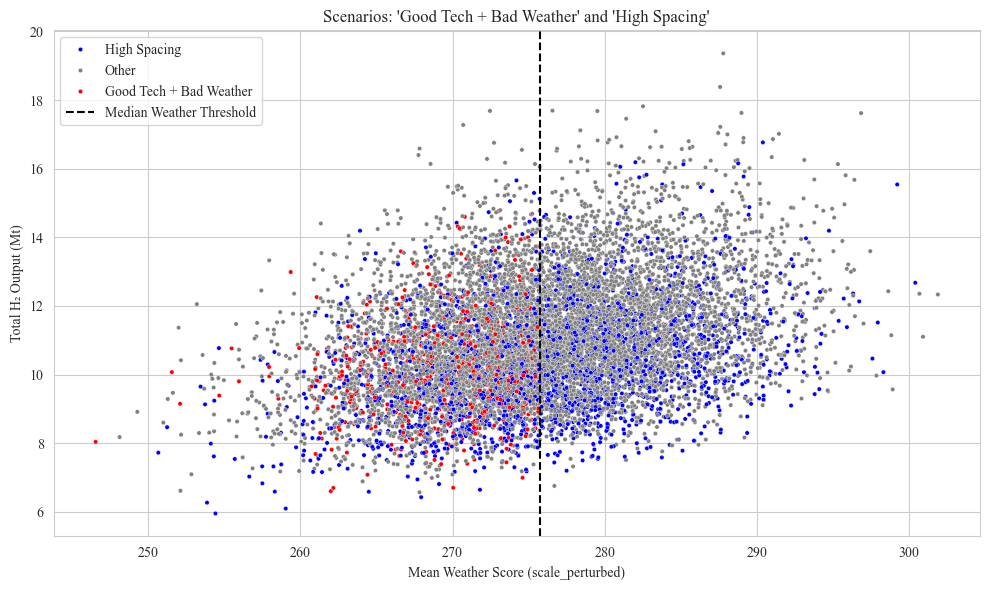

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and aggregate as before
df = pd.read_csv(r'C:\Users\mun93\OneDrive\PhD\Research Proposal\Project_2\h2_mc_df.csv')

agg_df = df.groupby('outer_sample').agg({
    'efficiency': 'mean',
    'electrolyser_efficiency': 'mean',
    'availability': 'mean',
    'spacing': 'mean',
    'scale_perturbed': 'mean',
    'h2_Mt': 'sum'
}).reset_index()

# Thresholds
tech_vars = ['efficiency', 'electrolyser_efficiency', 'spacing']
q3_tech = agg_df[tech_vars].quantile(0.50)  # median tech threshold
q1_weather = agg_df['scale_perturbed'].quantile(0.50)  # median weather
q3_spacing = agg_df['spacing'].quantile(0.75)  # high spacing

# Classification functions
def classify(row):
    if all(row[var] > q3_tech[var] for var in tech_vars) and row['scale_perturbed'] < q1_weather:
        return 'Good Tech + Bad Weather'
    elif row['spacing'] > q3_spacing:
        return 'High Spacing'
    else:
        return 'Other'

agg_df['scenario'] = agg_df.apply(classify, axis=1)

# Plot
plt.figure(figsize=(10, 6))
palette = {
    'Good Tech + Bad Weather': 'red',
    'High Spacing': 'blue',
    'Other': 'grey'
}
sns.scatterplot(
    data=agg_df,
    x='scale_perturbed',
    y='h2_Mt',
    hue='scenario',
    palette=palette,
    s=10
)

plt.axvline(q1_weather, color='black', linestyle='--', label='Median Weather Threshold')
plt.title("Scenarios: 'Good Tech + Bad Weather' and 'High Spacing'")
plt.xlabel("Mean Weather Score (scale_perturbed)")
plt.ylabel("Total H₂ Output (Mt)")
plt.legend()
plt.tight_layout()
plt.show()
